# 便利機能色々
- utils
- feature_selection
- preprocess

下ごしらえ

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.datasets import load_breast_cancer
breast=load_breast_cancer()
data=breast.data
target=breast.target
feature_name=breast.feature_names

dataをposiとnegaに分割しておく

In [3]:
malignant=data[target==0]
benign=data[target==1]

# 今回のお題

## 便利機能その1 utils
- utils.reshape
- utils.shuffle

In [4]:
from sklearn import utils

breast_cancerのposiとnegaの比率を見てみると...

In [5]:
for i,j in enumerate(breast.target_names):
    print("{}: {}".format(j,target[target==i].shape[0]))
# 良性の患者がちょっと多め

malignant: 212
benign: 357


posiとnegaからそれぞれresampleする

In [6]:
malignant_resample=utils.resample(malignant,n_samples=200)
benign_resample=utils.resample(benign,n_samples=200)

In [7]:
print(benign_resample.shape)
print(malignant_resample.shape)

(200, 30)
(200, 30)


使うときはresampleした結果をmergeする（列方向に結合）

In [8]:
# np.r_で列方向に結合できる。
data_resample=np.r_[malignant_resample,benign_resample]
target_resample=np.r_[[0 for i in range(200)],[1 for i in range(200)]]

In [9]:
print(data_resample.shape)
print(target_resample.shape)

(400, 30)
(400,)


utils.shuffleの使い方

In [10]:
data_shuffle, target_shuffle = utils.shuffle(data_resample, target_resample)

In [11]:
target_shuffle[0:10]

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0])

関数を一個にまとめておかないとseedが変わってしまい、バラバラになってしまうので注意。

## 便利機能その2
- feature_selection.SelectKBest
- feature_selection.SelectFromMedel

In [12]:
from sklearn import feature_selection as fs

In [13]:
selector=fs.SelectKBest(fs.chi2,k=3)
selector.fit(data,target)
pd.DataFrame(selector.transform(data)).head()

0       1       2
0  1001.0  153.40  2019.0
1  1326.0   74.08  1956.0
2  1203.0   94.03  1709.0
3   386.1   27.23   567.7
4  1297.0   94.44  1575.0

ざっくりというと、単変量解析して重要な特徴量を抽出する。  
（厳密には違うらしい）  
特徴量のスコアリングは下記が使える
- 回帰: f_regression, mutual_info_regression
- 分類: chi2, f_classif, mutual_info_classif

scores_に各特徴量のスコアも入っている。  
でも特徴量名をとってくるのはちょいと面倒。

In [14]:
pd.DataFrame(selector.scores_).T

0          1            2             3         4         5   \
0  266.104917  93.897508  2011.102864  53991.655924  0.149899  5.403075   

          6          7        8         9     ...             20        21  \
0  19.712354  10.544035  0.25738  0.000074    ...     491.689157  174.4494   

            22             23        24         25         26         27  \
0  3665.035416  112598.431564  0.397366  19.314922  39.516915  13.485419   

         28        29  
0  1.298861  0.231522  

[1 rows x 30 columns]

In [15]:
threshhold=sorted(selector.scores_,reverse=True)[3]
print (threshhold)
feature_name[selector.scores_>threshhold]

3665.03541634


array(['mean area', 'area error', 'worst area'], 
      dtype='<U23')

SelectPercentileは、同様にしてK％の特徴量を選択する。

SelectFromModelを使うと、あるモデルで重要だった特徴量のみを抽出できる。

In [16]:
from sklearn.linear_model import ElasticNet
en=ElasticNet().fit(data,target)

In [17]:
selector_en=fs.SelectFromModel(en, prefit=True,threshold="mean")
pd.DataFrame(selector_en.transform(data)).head()

0       1
0  17.33  184.60
1  23.41  158.80
2  25.53  152.50
3  26.50   98.87
4  16.67  152.20

特徴量名を取ってきたいならこんな感じ。

In [18]:
feature_name[abs(selector_en.estimator.coef_)>selector_en.threshold_]

array(['worst texture', 'worst perimeter'], 
      dtype='<U23')

これ以上はドキュメントを参照。  
RFE(recursive feature elimination)などもある。  
http://scikit-learn.org/dev/modules/feature_selection.html

# 便利機能その3 joblib.dump/load
externalsはsklearn以外のライブラリでjoblibとsixが使える。  
joblib自体が便利。  
http://postd.cc/my-top-5-new-python-modules-of-2015/  
http://blog.kzfmix.com/entry/1460182592  

In [19]:
from sklearn.externals import joblib

joblibのdumpとloadは、pickleよりも効率的に永続化できるらしいので、sklearnではモデルのsave/loadはこれを使う。

In [20]:
joblib.dump(selector, 'selector.pkl', compress=True) 
selector_2 = joblib.load('selector.pkl')

In [21]:
selector_2

SelectKBest(k=3, score_func=<function chi2 at 0x7fdf80cd12f0>)

# 便利機能その4 preprocessing

In [22]:
from sklearn import preprocessing

preprocessもきりがないので、簡単なのだけ。  
preprocessはfitとtransformを一緒にやることがほとんどなので、fit_transformというメソッドがある。

In [23]:
# mean=0, std=1にスケーリング
data_st=preprocessing.StandardScaler().fit_transform(data)

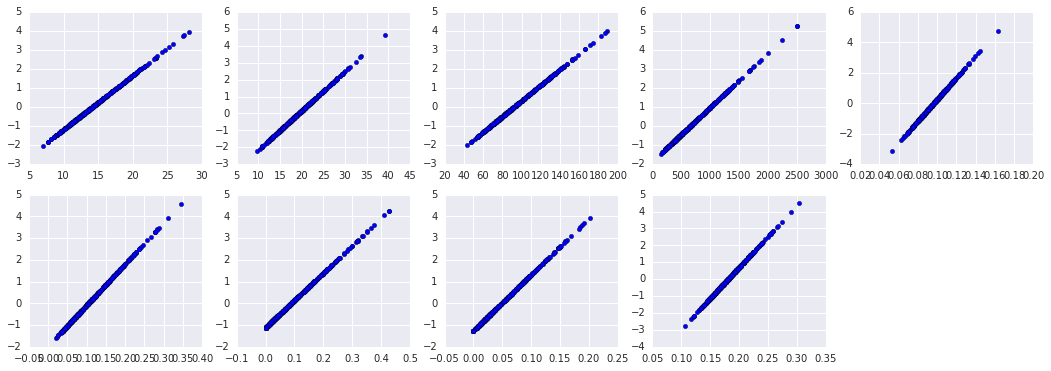

In [24]:
plt.figure(figsize=(18, 6))
for i in range(0,9):
    plt.subplot(251+i)
    plt.scatter(data[:,i],data_st[:,i])

標準正規分布にスケーリング

In [25]:
# これだけ問答無用で変換されてしまう
pd.DataFrame(preprocessing.scale(data)).head()

0         1         2         3         4         5         6   \
0  1.097064 -2.073335  1.269934  0.984375  1.568466  3.283515  2.652874   
1  1.829821 -0.353632  1.685955  1.908708 -0.826962 -0.487072 -0.023846   
2  1.579888  0.456187  1.566503  1.558884  0.942210  1.052926  1.363478   
3 -0.768909  0.253732 -0.592687 -0.764464  3.283553  3.402909  1.915897   
4  1.750297 -1.151816  1.776573  1.826229  0.280372  0.539340  1.371011   

         7         8         9     ...           20        21        22  \
0  2.532475  2.217515  2.255747    ...     1.886690 -1.359293  2.303601   
1  0.548144  0.001392 -0.868652    ...     1.805927 -0.369203  1.535126   
2  2.037231  0.939685 -0.398008    ...     1.511870 -0.023974  1.347475   
3  1.451707  2.867383  4.910919    ...    -0.281464  0.133984 -0.249939   
4  1.428493 -0.009560 -0.562450    ...     1.298575 -1.466770  1.338539   

         23        24        25        26        27        28        29  
0  2.001237  1.307686  2.616665  2.109526  2.296076  2.750622  1.937015  
1  1.890489 -0.375612 -0.430444 -0.146749  1.087084 -0.243890  0.281190  
2  1.456285  0.527407  1.082932  0.854974  1.955000  1.152255  0.201391  
3 -0.550021  3.394275  3.893397  1.989588  2.175786  6.046041  4.935010  
4  1.220724  0.220556 -0.313395  0.613179  0.729259 -0.868353 -0.397100  

[5 rows x 30 columns]

ベクトルのノルムを正規化

In [26]:
pd.DataFrame(preprocessing.Normalizer(norm="l1").fit_transform(data)).head()

0         1         2         3         4         5         6   \
0  0.005045  0.002911  0.034435  0.280693  0.000033  0.000078  0.000084   
1  0.005499  0.004750  0.035526  0.354458  0.000023  0.000021  0.000023   
2  0.005813  0.006273  0.038378  0.355140  0.000032  0.000047  0.000058   
3  0.009210  0.016435  0.062564  0.311371  0.000115  0.000229  0.000195   
4  0.006081  0.004298  0.040489  0.388709  0.000030  0.000040  0.000059   

         7         8         9     ...           20        21        22  \
0  0.000041  0.000068  0.000022    ...     0.007117  0.004860  0.051764   
1  0.000019  0.000048  0.000015    ...     0.006680  0.006258  0.042449   
2  0.000038  0.000061  0.000018    ...     0.006958  0.007537  0.045020   
3  0.000085  0.000209  0.000079    ...     0.012024  0.021371  0.079734   
4  0.000031  0.000054  0.000018    ...     0.006755  0.004996  0.045614   

         23        24        25        26        27        28        29  
0  0.566152  0.000045  0.000187  0.000200  0.000074  0.000129  0.000033  
1  0.522866  0.000033  0.000050  0.000065  0.000050  0.000074  0.000024  
2  0.504518  0.000043  0.000125  0.000133  0.000072  0.000107  0.000026  
3  0.457822  0.000169  0.000699  0.000554  0.000208  0.000535  0.000140  
4  0.472025  0.000041  0.000061  0.000120  0.000049  0.000071  0.000023  

[5 rows x 30 columns]

# おしまい
@y__sama